## Judul: Klasifikasi Emosi Berdasarkan Ekspresi Wajah Menggunakan Metode Pengolahan Citra


Nama Anggota
1. GIAN KAUSARI : F1D02310053
2. INTAN NURGITASARI : F1D02310060
3. DZAKANOV INSHOOFI : F1D02310110
4. NANANG ALIFIAN RIZKI FAKHRONI : F1D02310128


# Percobaan Menggunakan Ekualisasi Histogram, Deteksi Tepi Sobel dan Filter Median

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Kode di atas bertujuan untuk mengimpor berbagai library yang dibutuhkan untuk menjalankan proses pengolahan citra dan klasifikasi data. Modul `os` berfungsi untuk menjelajahi direktori dan membaca file yang tersimpan. Library `cv2` atau OpenCV digunakan dalam proses pembacaan dan manipulasi gambar. Library  `matplotlib.pyplot` berfungsi untuk menampilkan gambar serta membuat berbagai jenis grafik. lalu library `numpy` untuk pengolahan data numerik dan array, sedangkan `pandas` dipakai untuk mengelola data dalam format tabel atau dataframe.

Fungsi `train_test_split` dan `cross_val_predict` digunakan dalam pembagian data menjadi data latih dan data uji, serta untuk melakukan validasi silang. Fungsi `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `classification_report`, `confusion_matrix`, dan `ConfusionMatrixDisplay` berfungis  Untuk mengevaluasi performa model klasifikasi, digunakan beberapa metrik seperti .

Ekstraksi fitur tekstur dari gambar dilakukan dengan menggunakan `graycomatrix` dan `graycoprops`, yang merupakan bagian dari metode GLCM (Gray Level Co-occurrence Matrix). Selain itu, fungsi `entropy` digunakan untuk menghitung nilai entropi dari fitur tekstur.

Dalam hal klasifikasi, digunakan tiga algoritma utama, yaitu `RandomForestClassifier`, `SVC` (Support Vector Classifier), dan `KNeighborsClassifier`. library `seaborn` berfungsi untuk mendukung visualisasi data seperti heatmap atau grafik lainnya.

# Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder[0] == ".":
        continue

    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)

        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


Kode di atas digunakan untuk membaca seluruh gambar dalam folder `dataset`, yang di dalamnya terdiri dari beberapa subfolder. Setiap subfolder dianggap sebagai representasi dari satu kelas atau kategori gambar.

Pertama, disiapkan tiga list kosong yaitu `data`, `labels`, dan `file_name` untuk menyimpan gambar grayscale, label kelas berdasarkan nama subfolder, serta nama file asli dari gambar.

Program kemudian melakukan iterasi ke seluruh subfolder. Jika ada folder yang diawali dengan titik (biasanya folder sistem tersembunyi), maka akan dilewati agar tidak ikut diproses.

Setiap gambar di dalam subfolder akan dibaca menggunakan OpenCV dalam mode grayscale. Hasil pembacaan gambar disimpan ke `data`, nama subfolder yang menjadi label dimasukkan ke `labels`, dan nama filenya disimpan ke `file_name`.

Setelah semua gambar terbaca, list `data` dan `labels` dikonversi menjadi array NumPy. Ini bertujuan agar data lebih efisien untuk diproses lebih lanjut, seperti saat melakukan ekstraksi fitur atau klasifikasi.


# Data Preparation

## Define Preprocessing Function

In [3]:
def resize(image, target_size):
    result = np.zeros(target_size, image.dtype)
    step = (image.shape[0] // target_size[0], image.shape[1] // target_size[1])
    result = image[0::step[0], 0::step[1]]
    return result

Kode di atas merupakan fungsi untuk mengubah ukuran (resize) citra secara manual ke dimensi yang diinginkan. Awalnya, fungsi ini membuat array kosong bernama `result` dengan ukuran `target_size` dan tipe data yang sama dengan gambar asli. Kemudian, langkah atau jarak antar piksel yang akan diambil dari citra asli dihitung melalui pembagian ukuran asli dengan ukuran target. Selanjutnya, citra hasil resize diambil menggunakan teknik slicing berdasarkan langkah tersebut, yaitu memilih piksel secara berkala dari gambar asli. Hasil akhirnya adalah citra baru yang ukurannya telah diperkecil atau diperbesar sesuai kebutuhan.

In [4]:
# Ekualisasi Histogram
def prepro1(img):
    result = np.zeros(img.shape, dtype=img.dtype)

    eqs: np.array = np.zeros(256, np.uint8)

    hist: np.array = np.zeros(256, np.int32)
    for c in img.ravel():
        hist[int(c)] += 1

    cdf: np.array = np.zeros(256, float)

    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = hist[i] + cdf[i - 1]

    eqs = np.round(cdf / cdf[-1] * 255).astype(np.uint8)
    
    result = eqs[img]

    return result

Kode fungsi `prepro1(img)` berfungsi untuk melakukan proses penyetaraan histogram (histogram equalization) pada citra grayscale yang diberikan sebagai input `img`. Proses dimulai dengan membuat sebuah array kosong bernama `result` yang memiliki ukuran dan tipe data sama dengan citra asli, yang nantinya akan menyimpan hasil citra yang sudah diolah. Selanjutnya, kode membuat histogram dari citra tersebut dengan menghitung frekuensi kemunculan tiap nilai intensitas pixel dari 0 hingga 255 dan menyimpannya dalam array `hist`. Setelah itu, dilakukan perhitungan fungsi distribusi kumulatif (CDF) yang merupakan penjumlahan kumulatif dari histogram untuk setiap intensitas, dan hasilnya disimpan dalam array `cdf`. Nilai-nilai CDF tersebut kemudian dinormalisasi dan diubah skalanya menjadi rentang 0 hingga 255, yang menghasilkan array `eqs` sebagai peta transformasi intensitas pixel. Pada tahap akhir, setiap pixel pada citra asli diganti dengan nilai yang telah ditransformasikan oleh `eqs`, dan hasilnya disimpan di `result`. Fungsi kemudian mengembalikan citra baru dengan kontras yang lebih merata, sehingga citra menjadi lebih jelas dan detailnya lebih mudah terlihat.


In [5]:
# Perbaikan Citra - Filter Median
def prepro2(img, size=(3, 3)):
    result = np.zeros(img.shape, img.dtype)

    half_kern_size = (size[0]//2 ,size[1]//2)
    padded = np.pad(img, pad_width=half_kern_size, mode="edge")
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            temp = np.sort(padded[y:y+size[0], x:x+size[1]].flatten())[(size[0] * size[1]) // 2]
            result[y,x] = temp

    return result

kode di atas merupakan fungsi `prepro2(img, size=(3, 3))` yang berfungsi untuk melakukan perbaikan citra menggunakan filter median. Pertama, fungsi ini membuat array kosong `result` dengan ukuran dan tipe data yang sama seperti citra input `img`, yang akan menampung hasil filtering. Variabel `half_kern_size` menghitung setengah ukuran kernel pada masing-masing sumbu (vertikal dan horizontal), yang berguna untuk proses padding. Kemudian, citra asli `img` dipadding menggunakan metode "edge", yaitu dengan menyalin nilai piksel tepi citra ke bagian padding. Ini memastikan proses filter median tetap bisa berjalan di piksel-piksel tepi. Selanjutnya, fungsi melakukan iterasi untuk setiap piksel dalam citra. Pada tiap posisi piksel `(y, x)`, diambil area kecil sesuai ukuran kernel dari citra yang telah dipadding, kemudian seluruh nilai piksel dalam area tersebut diratakan menjadi satu dimensi (flatten), diurutkan, dan diambil nilai median-nya (yaitu nilai tengah dari hasil sorting). Nilai ini lalu disimpan ke dalam `result[y, x]`. Dengan demikian, fungsi ini menggantikan setiap piksel dengan nilai median dari tetangganya, sehingga citra yang dihasilkan akan tampak lebih bersih dari noise, namun tetap mempertahankan tepi objek dengan baik.


In [6]:
# Deteksi Tepi - Metode Sobel
def prepro4(img):
    kernel = np.array([
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ],
        [
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

Kode di atas merupakan fungsi `prepro4(img)` yang berfungsi untuk melakukan deteksi tepi pada citra grayscale menggunakan metode Sobel. Pertama, fungsi ini mendefinisikan dua kernel Sobel yang masing-masing untuk mendeteksi gradien intensitas arah horizontal (`kernel[0]`) dan vertikal (`kernel[1]`). Kemudian dibuat array `result` kosong untuk menyimpan hasil deteksi tepi dengan ukuran sama dan tipe data yang sama dengan citra input `img`. Agar proses konvolusi kernel dengan citra berjalan lancar tanpa masalah pada tepi citra, citra `img` dipadding dengan membuat array `padded` yang lebih besar dua piksel di setiap sisi, dan nilai piksel citra asli disalin ke dalam posisi yang tepat di dalam `padded`. Selanjutnya, dilakukan perulangan pada setiap piksel di `result`, di mana untuk setiap piksel dihitung hasil konvolusi dengan kernel horizontal (`sx`) dan vertikal (`sy`) dari area citra yang sesuai di `padded`. Besarnya gradien tepi pada piksel tersebut dihitung menggunakan rumus akar kuadrat dari jumlah kuadrat `sx` dan `sy`. Nilai ini kemudian disimpan di `result`. Dengan cara ini, fungsi mengembalikan citra hasil deteksi tepi yang menunjukkan perubahan intensitas paling signifikan pada citra asli, yang membantu menonjolkan kontur dan batas objek.


## Preprocessing

In [7]:
dataPreprocessed = []
for i in range(len(data)):
    img = prepro1(data[i])
    img = prepro4(img)
    img = prepro2(img)
    dataPreprocessed.append(img)

Kode di atas merupakan proses praproses citra yang diterapkan pada setiap gambar dalam list `data`. Pertama, gambar diproses dengan fungsi `prepro1()` untuk melakukan ekualisasi histogram guna meningkatkan kontras citra. Selanjutnya, hasilnya diteruskan ke fungsi `prepro4()` untuk deteksi tepi menggunakan metode Sobel agar batas-batas objek menjadi lebih jelas. Terakhir, fungsi `prepro2()` diterapkan untuk mengurangi noise pada citra hasil deteksi tepi menggunakan median filter. Citra yang telah melalui ketiga tahap ini kemudian disimpan dalam list `dataPreprocessed.


Kode di bawah ini berfungsi untuk menampilkan gambar-gambar hasil pra-pemrosesan dari setiap label secara berkelompok. Pertama, variabel `step` diset ke angka 100, yang berarti dalam dataset, setiap label memiliki 100 gambar. Kemudian dilakukan iterasi dengan perulangan `for i in range(len(dataPreprocessed) // step)` untuk membagi data berdasarkan jumlah label. Dalam setiap iterasi, `plt.title(labels[i * step])` digunakan untuk memberikan judul sesuai label gambar saat ini.

Selanjutnya, `for j in range(0, 20):` digunakan untuk menampilkan 20 gambar pertama dari masing-masing label. Gambar-gambar ini ditempatkan dalam grid 4x5 menggunakan `plt.subplot(4, 5, j + 1)`, dan masing-masing ditampilkan dalam skala abu-abu melalui. Fungsi `plt.axis(False)` menyembunyikan sumbu agar tampilan lebih bersih.

Setelah menampilkan semua subplot, `plt.figure(figsize=(20, 20))` digunakan untuk mengatur ukuran keseluruhan tampilan gambar, lalu `plt.tight_layout()` merapikan tata letak subplot agar tidak saling bertabrakan, dan akhirnya `plt.show()` menampilkan hasil visualisasinya. Dengan pendekatan ini, visualisasi tiap label dari data yang telah dipra-proses dapat ditampilkan secara sistematis dan rapi.


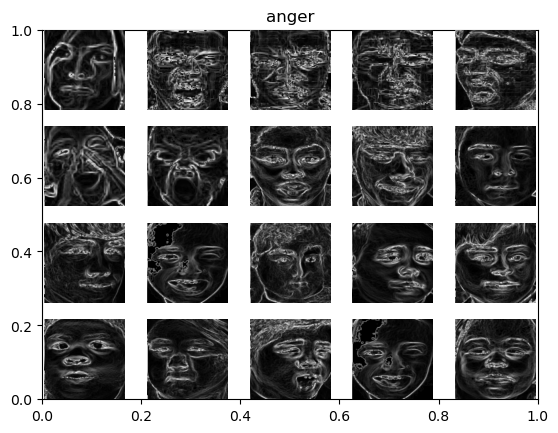

<Figure size 2000x2000 with 0 Axes>

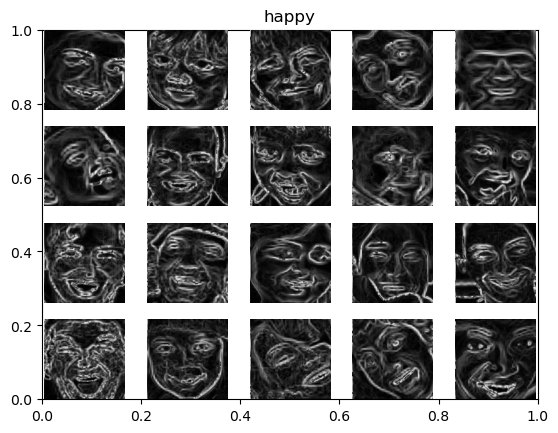

<Figure size 2000x2000 with 0 Axes>

In [8]:
step = 100 # Jumlah Gambar Per Label
for i in range(len(dataPreprocessed) // step):
    plt.title(labels[i * step])
    for j in range(0, 20):
        plt.subplot(4, 5, j + 1)
        plt.imshow(dataPreprocessed[(i * step) + j], cmap="gray")
        plt.axis(False)

    plt.figure(figsize=(20, 20))
    plt.tight_layout()
    plt.show()

## Feature Extraction

In [9]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas adalah fungsi bernama `glcm` yang digunakan untuk membuat matriks GLCM (Gray Level Co-occurrence Matrix) dari sebuah citra. Fungsi ini menerima dua parameter: `image` sebagai input citra dan `derajat` yang menentukan sudut arah matriks (hanya menerima nilai 0, 45, 90, atau 135 derajat). Berdasarkan nilai `derajat`, fungsi akan memilih sudut dalam radian yang sesuai. Setelah itu, fungsi memanggil `graycomatrix` dari pustaka skimage untuk membuat matriks GLCM dengan jarak 1 dan sudut yang telah ditentukan, menggunakan 256 level abu-abu, serta dengan opsi simetris dan normalisasi. Akhirnya, fungsi mengembalikan matriks GLCM yang telah dibuat.


In [10]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Kode di atas merupakan fungsi `correlation(matriks)` yang berperan untuk menghitung nilai korelasi tekstur dari suatu matriks GLCM (Gray Level Co-occurrence Matrix) yang sudah terbentuk dari citra grayscale. Fungsi ini menggunakan fungsi `graycoprops` dari pustaka `skimage.feature`, yang secara khusus mengambil properti statistik dengan nama `'correlation'`, yaitu ukuran seberapa piksel dalam gambar berhubungan secara linier berdasarkan nilai keabuan. Nilai korelasi dihitung dari distribusi pasangan piksel berdasarkan arah dan jarak tertentu, dan hasilnya diakses pada indeks `[0, 0]` karena GLCM biasanya hanya memiliki satu pasangan arah dan jarak pada implementasi umum. Fungsi ini penting dalam analisis tekstur karena korelasi dapat membedakan pola-pola keteraturan dalam permukaan gambar.


In [11]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Kode di atas merupakan fungsi `dissimilarity(matriks)` yang digunakan untuk menghitung nilai ketidaksamaan tekstur dari matriks GLCM (Gray Level Co-occurrence Matrix). Nilai ini diperoleh dengan memanggil fungsi `graycoprops` dari pustaka `skimage.feature`, lalu mengambil properti `'dissimilarity'`, yang merepresentasikan seberapa besar perbedaan nilai keabuan antar pasangan piksel dalam gambar. Hasilnya diambil dari indeks `[0, 0]` karena umumnya hanya satu kombinasi jarak dan sudut yang digunakan. Fungsi ini sangat bermanfaat untuk membedakan tingkat kontras halus dalam analisis tekstur citra digital.


In [12]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Kode di atas merupakan fungsi `homogenity(matriks)` yang digunakan untuk menghitung nilai homogenitas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix).** Fungsi ini memanfaatkan metode `graycoprops` dari pustaka `skimage.feature`, dengan parameter `'homogeneity'` yang berfungsi untuk menilai sejauh mana intensitas piksel dalam citra yang saling berdekatan memiliki kemiripan. Nilai homogenitas yang tinggi menunjukkan bahwa gambar memiliki tekstur yang seragam atau halus. Output dari fungsi ini diakses melalui indeks `[0, 0]` karena biasanya hanya satu arah dan satu jarak yang dihitung dalam GLCM. Nilai ini sering digunakan dalam ekstraksi fitur untuk analisis citra berbasis tekstur.


In [13]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Kode di atas merupakan fungsi `contrast(matriks)` yang berfungsi untuk menghitung nilai kontras dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'contrast'`, yang mengukur tingkat perbedaan intensitas antara piksel yang berdekatan pada citra. Nilai kontras yang tinggi menunjukkan adanya variasi tekstur yang besar, seperti tepi atau pola yang mencolok pada gambar. Fungsi ini mengembalikan hasil perhitungan pada indeks `[0, 0]` karena biasanya GLCM dihitung pada satu arah dan jarak tertentu. Nilai kontras ini penting dalam analisis tekstur untuk pengenalan pola atau klasifikasi citra.


In [14]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Kode di atas merupakan fungsi `ASM(matriks)` yang berfungsi untuk menghitung nilai Angular Second Moment (ASM) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'ASM'`, yang mengukur tingkat homogenitas atau keseragaman tekstur pada citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih seragam dan konsisten. Fungsi ini mengembalikan nilai hasil perhitungan pada indeks `[0, 0]` karena biasanya GLCM dihitung untuk satu arah dan jarak tertentu. ASM sering dipakai dalam analisis tekstur untuk mendeteksi pola dan karakteristik visual pada gambar.


In [15]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Kode di atas merupakan fungsi `energy(matriks)` yang berfungsi untuk menghitung nilai energi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'energy'`, yang mengukur kekuatan atau intensitas tekstur pada citra. Nilai energi menunjukkan seberapa konsisten dan berulang pola dalam tekstur gambar; semakin tinggi nilai energi, semakin homogen teksturnya. Fungsi ini mengembalikan nilai energi pada indeks `[0, 0]`, karena biasanya GLCM dihitung pada satu arah dan jarak tertentu. Energi merupakan salah satu fitur penting dalam analisis tekstur untuk pengenalan pola dan klasifikasi citra.

In [16]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode di atas merupakan fungsi `entropyGlcm(matriks)` yang berfungsi untuk menghitung entropi dari matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan `entropy` dari pustaka `scipy.stats`, dengan input berupa matriks yang sudah diratakan menjadi vektor satu dimensi menggunakan `matriks.ravel()`. Entropi mengukur tingkat ketidakpastian atau kompleksitas dalam tekstur citra; semakin tinggi nilai entropi, semakin kompleks dan acak pola teksturnya. Fungsi ini mengembalikan nilai entropi yang merupakan indikator penting dalam analisis tekstur untuk membedakan karakteristik permukaan dalam pengolahan citra.


In [17]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas berfungsi untuk menjalankan proses perhitungan matriks GLCM atau Gray Level Co-occurrence Matrix pada empat arah sudut berbeda, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra yang telah dipraproses dan disimpan dalam list `dataPreprocessed`. Pada awalnya, dibuat empat list kosong dengan nama `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` yang masing-masing list tersebut akan digunakan untuk menyimpan hasil perhitungan GLCM sesuai arah sudutnya. kemudian dilakukan proses iterasi menggunakan perulangan `for i in range(len(dataPreprocessed))`, yang berarti setiap elemen (gambar) dalam `dataPreprocessed` akan diproses satu per satu. Di dalam perulangan, fungsi `glcm()` dipanggil dengan parameter gambar dan sudutnya, sehingga dihasilkan empat buah variabel GLCM per gambar: `D0`, `D45`, `D90`, dan `D135`. Masing-masing variabel tersebut kemudian dimasukkan ke dalam list-nya masing-masing dengan metode `.append()`. Hasil akhir dari kode ini adalah empat kumpulan GLCM yang siap digunakan untuk proses ekstraksi ciri tekstur seperti contrast, correlation, energy, atau homogeneity dari gambar.


In [18]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode di atas bertujuan untuk menyiapkan struktur data berupa list kosong yang akan digunakan untuk menyimpan hasil ekstraksi fitur tekstur dari gambar berdasarkan matriks GLCM pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°. Setiap nama list menggambarkan jenis fitur yang akan dihitung, seperti `Kontras`, `dissimilarity`, `homogenity`, `entropy`, `ASM`, `energy`, dan `correlation`, yang masing-masing merepresentasikan ciri statistik dari tekstur citra. Misalnya, `Kontras0` akan menyimpan nilai kontras dari GLCM yang dihitung pada sudut 0°, `entropy90` akan menyimpan nilai entropi dari GLCM pada sudut 90°, dan seterusnya. Penamaan variabel ini menggunakan kombinasi nama fitur dan sudut untuk mempermudah proses pengelompokan, analisis, serta visualisasi data fitur tekstur dari citra nantinya.


In [19]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di atas berfungsi untuk menghitung nilai fitur correlation dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `correlation()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai korelasi berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `correlation0`, `correlation45`, `correlation90`, dan `correlation135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `C0`, `C45`, `C90`, dan `C135` bersifat sementara, sedangkan list `correlation0`, `correlation45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.


In [20]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas berfungsi untuk menghitung nilai fitur kontras dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `contrast()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai kontras berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `K0`, `K45`, `K90`, dan `K135` bersifat sementara, sedangkan list `Kontras0`, `Kontras45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.


In [21]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas berfungsi untuk menghitung nilai fitur dissimilarity dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `dissimilarity()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai dissimilarity berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `Dis0`, `Dis45`, `Dis90`, dan `Dis135` bersifat sementara, sedangkan list `dissimilarity0`, `dissimilarity45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.

In [22]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas berfungsi untuk menghitung nilai fitur homogenity dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `homogenity()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai homogenitas berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel sementara `H0`, `H45`, `H90`, dan `H135` hanya berlaku untuk satu iterasi saja, sedangkan list `homogenity0`, `homogenity45`, dan seterusnya menyimpan hasil akhir dari semua gambar.


In [23]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di atas berfungsi untuk menghitung nilai fitur entropy dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `entropyGlcm()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai entropi berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `E0`, `E45`, `E90`, dan `E135` bersifat sementara, sedangkan list `entropy0`, `entropy45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.

In [24]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas berfungsi untuk menghitung nilai fitur ASM dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `ASM()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai ASM berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `A0`, `A45`, `A90`, dan `A135` bersifat sementara, sedangkan list `ASM0`, `ASM45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.


In [25]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas berfungsi untuk menghitung nilai fitur energy dari matriks GLCM (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang sebelumnya telah dihitung dari gambar-gambar dalam `dataPreprocessed`. Setiap elemen dalam list `Derajat0`, `Derajat45`, dan seterusnya berisi matriks GLCM untuk satu citra pada sudut tertentu (0°, 45°, 90°, 135°). Fungsi `energy()` yang digunakan akan mengambil satu matriks dan mengembalikan nilai energy berdasarkan properti GLCM. Hasil perhitungan ini kemudian disimpan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135` sesuai dengan sudut GLCM-nya. Dengan demikian, variabel `ER0`, `ER45`, `ER90`, dan `ER135` bersifat sementara, sedangkan list `energy0`, `energy45`, dan seterusnya menyimpan hasil akhir untuk semua gambar.

## Write the extraction's results to CSV

Kode di bawah membuat sebuah dictionary bernama `dataTable` yang berisi kumpulan data fitur tekstur hasil ekstraksi dari gambar, lengkap dengan nama file (`file_name`) dan label (`labels`). Setiap fitur seperti kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi disimpan dalam list terpisah berdasarkan empat sudut orientasi (0°, 45°, 90°, dan 135°).

Kemudian, dictionary ini dikonversi menjadi sebuah DataFrame pandas (`df`) yang memudahkan pengelolaan data dalam bentuk tabel. Setelah itu, DataFrame disimpan ke file CSV dengan nama `hasil_ekstraksi_4.csv` tanpa menyimpan indeks baris. Terakhir, file CSV yang baru saja dibuat dibaca kembali menggunakan `pd.read_csv()` dan hasilnya ditampilkan sebagai output `hasilEkstrak`.

Dengan cara ini, data hasil ekstraksi fitur tekstur tersimpan secara rapi dan siap untuk analisis atau pengolahan lebih lanjut.


In [26]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_4.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_4.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,anger002.png,anger,287.427190,468.476181,217.551269,458.030666,0.341160,0.262800,0.354596,0.281358,...,0.001968,0.001329,0.042917,0.035403,0.044364,0.036461,0.928235,0.881745,0.945582,0.884391
1,anger003.png,anger,761.970532,1413.701824,870.849496,1405.643106,0.383513,0.268322,0.408081,0.267981,...,0.003412,0.001842,0.056116,0.043242,0.058414,0.042920,0.858557,0.736855,0.839656,0.738351
2,anger004.png,anger,610.593470,1195.846387,800.597494,1234.004866,0.351513,0.225492,0.314652,0.219032,...,0.001214,0.000767,0.040529,0.028125,0.034839,0.027704,0.869774,0.743378,0.830518,0.735191
3,anger006.png,anger,473.495476,1015.800981,724.932195,1023.193589,0.360078,0.239309,0.330212,0.235668,...,0.001798,0.001151,0.047572,0.034533,0.042400,0.033920,0.888381,0.759866,0.829804,0.758117
4,anger007.png,anger,479.872117,875.447385,527.726397,887.111122,0.330251,0.211670,0.319501,0.215772,...,0.001180,0.000708,0.035889,0.025930,0.034352,0.026611,0.888418,0.796216,0.880793,0.793517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,happy228.png,happy,236.002242,498.215950,302.185678,503.173078,0.398779,0.291655,0.374465,0.309862,...,0.002906,0.002239,0.057123,0.045919,0.053906,0.047321,0.935998,0.863089,0.918997,0.861748
196,happy238.png,happy,166.058816,423.115647,289.832940,408.488528,0.341553,0.244221,0.298118,0.234630,...,0.000955,0.000657,0.035351,0.026706,0.030911,0.025641,0.952409,0.877381,0.917241,0.881639
197,happy251.png,happy,146.250180,295.502282,179.867933,269.749140,0.340433,0.264643,0.338971,0.282211,...,0.001694,0.001208,0.040927,0.033692,0.041158,0.034750,0.950913,0.899195,0.939501,0.907979
198,happy262.png,happy,118.258889,311.658931,218.661635,308.035191,0.380418,0.306330,0.378963,0.291411,...,0.002020,0.001272,0.044349,0.037259,0.044940,0.035670,0.962329,0.899392,0.930147,0.900550


## Features Selection

Kata di bawah ini berfungsi untuk melakukan seleksi fitur dengan cara menghilangkan fitur-fitur yang memiliki korelasi sangat tinggi satu sama lain (lebih dari atau sama dengan threshold 0.95) agar mengurangi redundansi data dalam dataset `hasilEkstrak`. Pertama, variabel `correlation` menghitung matriks korelasi antar fitur kecuali kolom `Label` dan `Filename`. Kemudian, variabel `columns` berupa array boolean berukuran sama dengan jumlah fitur digunakan untuk menandai fitur yang akan dipertahankan. Dua buah loop `for` bertugas membandingkan korelasi setiap pasangan fitur; jika nilai korelasi antara dua fitur melewati batas threshold, fitur kedua akan diberi tanda `False` agar dikeluarkan dari seleksi. Setelah proses ini selesai, variabel `select` akan berisi daftar nama fitur yang lolos seleksi berdasarkan array `columns`. Data fitur yang telah disaring ini disimpan dalam variabel `x_new`, sedangkan variabel `y` menyimpan target kelas dari kolom `Label`. Terakhir, kode membuat visualisasi heatmap korelasi fitur terpilih menggunakan `seaborn` dengan ukuran gambar yang cukup besar untuk memudahkan analisis. Dengan demikian, kode ini membantu mempersiapkan dataset yang lebih optimal untuk proses pembelajaran mesin selanjutnya dengan menghindari fitur yang sangat mirip atau berlebihan.


<Axes: >

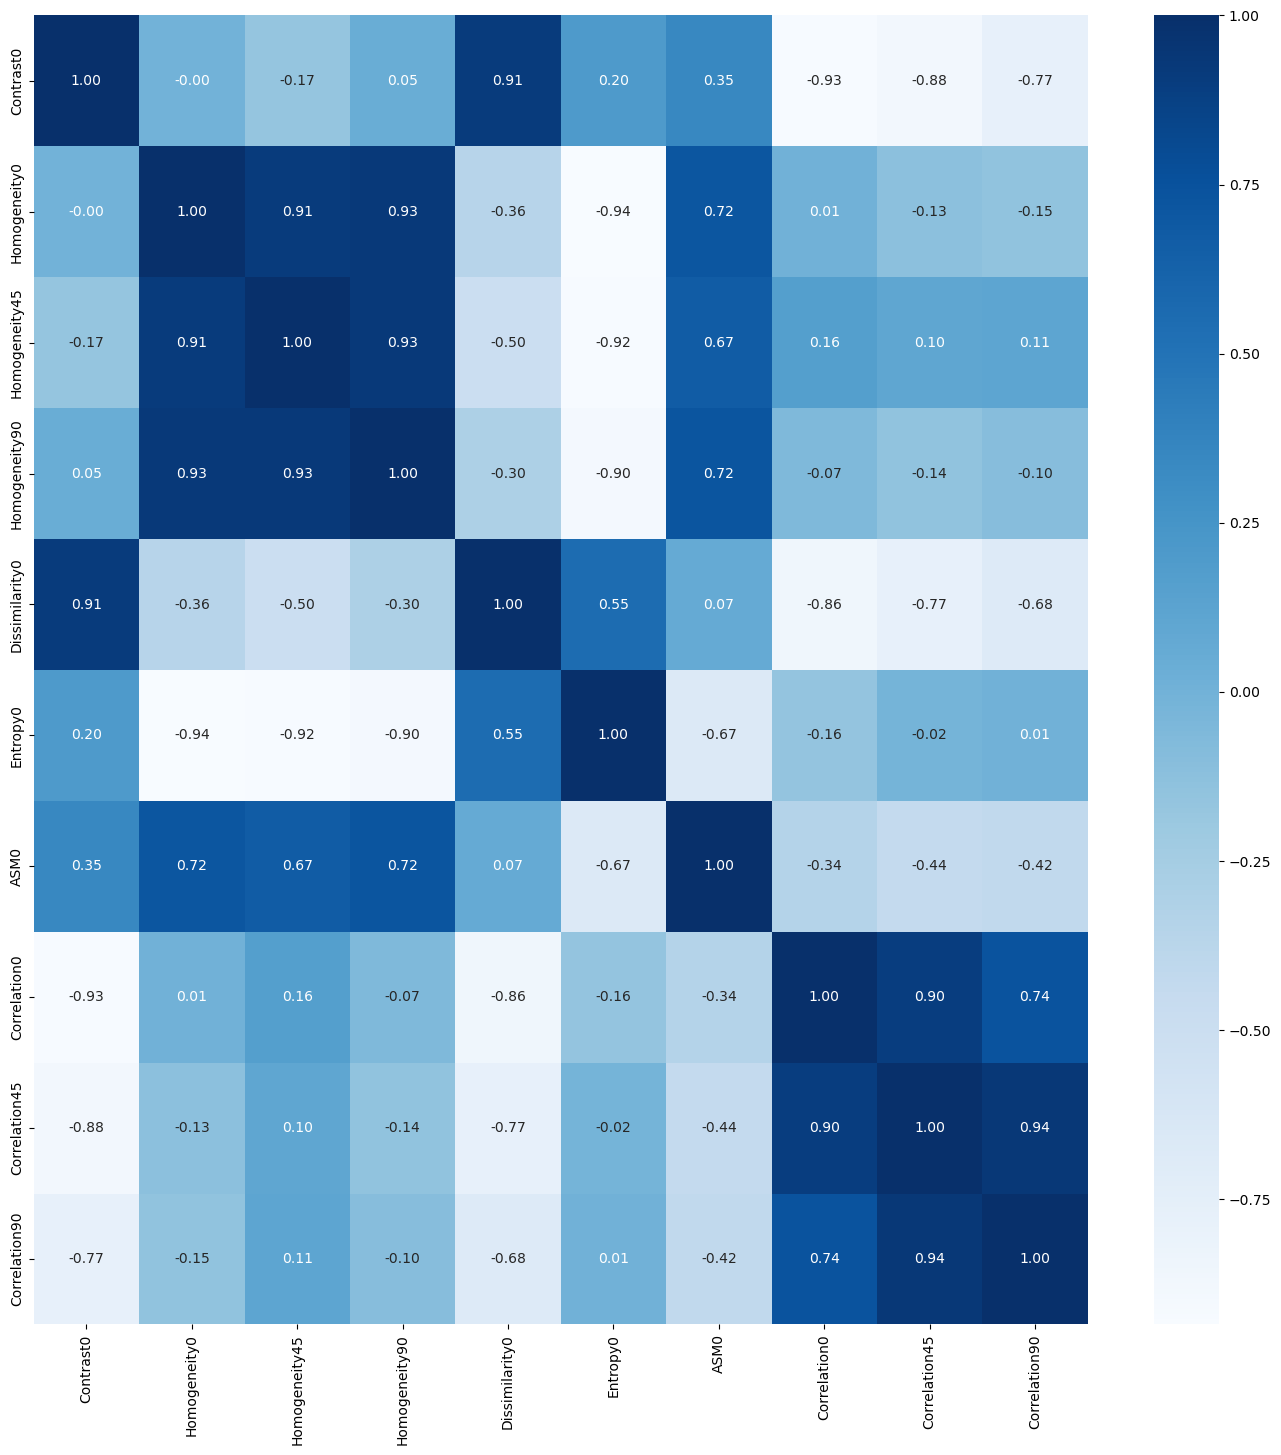

In [27]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [28]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 10)
(40, 10)


Kode di atas berfungsi untuk membagi dataset menjadi dua bagian utama, yaitu data latih dan data uji. Pemisahan ini dilakukan menggunakan fungsi `train_test_split` dari pustaka `sklearn.model_selection`. Nilai `test_size=0.2` menunjukkan bahwa 20% dari total data digunakan untuk pengujian, sedangkan sisanya, yaitu 80%, digunakan untuk pelatihan model. Pengaturan `random_state=42` ditambahkan agar hasil pembagian data bersifat tetap (reproducible) setiap kali kode dijalankan. Kemudian, `print(X_train.shape)` dan `print(X_test.shape)` digunakan untuk menampilkan ukuran masing-masing subset data, sehingga kita dapat memastikan proporsi pembagian data sudah sesuai. Pembagian ini penting agar model dapat belajar dari data latih dan diuji performanya secara objektif menggunakan data uji yang belum pernah dilihat sebelumnya.

## Feature Normalization

In [29]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode di atas merupakan proses normalisasi data menggunakan fungsi `mean()` dan `std()` pada variabel `X_train` dan `X_test`. Pada baris pertama, `X_test` dinormalisasi dengan mengurangi rata-rata `X_train.mean()` dan membagi dengan standar deviasi `X_train.std()`, agar skala data pengujian sama dengan data pelatihan. Baris kedua melakukan normalisasi yang sama pada `X_train`. Proses ini disebut z-score normalization, bertujuan membuat data memiliki rata-rata nol dan standar deviasi satu sehingga model dapat belajar dengan lebih baik tanpa terpengaruh perbedaan skala fitur.

# Modelling

## Define Modelling

In [30]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas berisi fungsi `generateClassificationReport` yang menerima dua parameter, `y_true` dan `y_pred`, untuk mencetak laporan klasifikasi menggunakan `classification_report`, menampilkan matriks kebingungan lewat `confusion_matrix`, dan menghitung akurasi dengan `accuracy_score`. Fungsi ini berguna untuk evaluasi performa model klasifikasi. Selanjutnya, tiga objek classifier didefinisikan: `rf` adalah Random Forest dengan 5 pohon keputusan dan `random_state` 42 untuk reproduksibilitas, `svm` adalah Support Vector Machine dengan kernel RBF, dan `knn` adalah K-Nearest Neighbors dengan jumlah tetangga 5. Variabel-variabel ini akan digunakan untuk melatih dan menguji model klasifikasi pada dataset.

## Train Random Forest Classifier

Kode di bawah berfungsi untuk menjalankan proses pelatihan dan evaluasi model Random Forest yang telah didefinisikan sebelumnya sebagai `rf`. Pertama, model dilatih dengan data fitur `X_train` dan label `y_train` menggunakan fungsi `fit()`. Setelah itu, prediksi dilakukan pada data pelatihan (`X_train`) dengan `predict()`, kemudian hasil prediksi `y_pred` dievaluasi dengan memanggil fungsi `generateClassificationReport` menggunakan label asli `y_train` dan prediksi `y_pred`. Langkah ini menghasilkan laporan performa model pada data pelatihan. Selanjutnya, proses prediksi dan evaluasi yang sama juga diterapkan pada data pengujian (`X_test` dan `y_test`) untuk mengukur kemampuan generalisasi model terhadap data baru. Output menampilkan hasil evaluasi untuk training set dan testing set secara berurutan.

In [31]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       anger       0.96      0.97      0.97        79
       happy       0.97      0.96      0.97        81

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

[[77  2]
 [ 3 78]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

       anger       0.88      0.67      0.76        21
       happy       0.71      0.89      0.79        19

    accuracy                           0.78        40
   macro avg       0.79      0.78      0.77        40
weighted avg       0.80      0.78      0.77        40

[[14  7]
 [ 2 17]]
Accuracy: 0.775


## Tain SVM Classifier

Kode di bawah digunakan untuk melatih dan menguji model Support Vector Machine (SVM) yang sudah didefinisikan sebagai `svm`. Pertama, model SVM dilatih menggunakan data fitur `X_train` dan label `y_train` dengan metode `fit()`. Setelah pelatihan selesai, prediksi dilakukan pada data pelatihan `X_train` menggunakan `predict()`, dan hasil prediksi `y_pred` dievaluasi dengan fungsi `generateClassificationReport` menggunakan label asli `y_train` dan hasil prediksi `y_pred`. Evaluasi ini memberikan gambaran performa model pada data pelatihan. Selanjutnya, proses prediksi dan evaluasi yang sama dilakukan pada data pengujian `X_test` dan `y_test` untuk mengukur seberapa baik model SVM dapat menggeneralisasi terhadap data baru. Hasil evaluasi untuk training dan testing set ditampilkan secara terpisah.


In [32]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       0.97      0.84      0.90        79
       happy       0.86      0.98      0.91        81

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[66 13]
 [ 2 79]]
Accuracy: 0.90625

------Testing Set------
              precision    recall  f1-score   support

       anger       0.94      0.76      0.84        21
       happy       0.78      0.95      0.86        19

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.87      0.85      0.85        40

[[16  5]
 [ 1 18]]
Accuracy: 0.85


## Train KNN Classifier

Kode di bawah digunakan untuk melatih model K-Nearest Neighbors (KNN) dengan data pelatihan `X_train` dan label `y_train` melalui fungsi `fit()`. Setelah model terlatih, dilakukan prediksi pada data pelatihan menggunakan `knn.predict(X_train)` yang hasilnya disimpan dalam variabel `y_pred`. Selanjutnya, hasil prediksi tersebut dievaluasi dengan fungsi `generateClassificationReport` yang menerima label asli `y_train` dan prediksi `y_pred`, untuk menampilkan laporan klasifikasi, confusion matrix, serta nilai akurasi pada data pelatihan. Proses yang sama kemudian diterapkan pada data pengujian `X_test` dengan prediksi dan evaluasi hasil terhadap label `y_test`. Dengan cara ini, kode menampilkan performa model KNN baik pada data pelatihan maupun data pengujian.

In [33]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       0.92      0.90      0.91        79
       happy       0.90      0.93      0.91        81

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[71  8]
 [ 6 75]]
Accuracy: 0.9125

------Testing Set------
              precision    recall  f1-score   support

       anger       0.89      0.76      0.82        21
       happy       0.77      0.89      0.83        19

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.82        40
weighted avg       0.83      0.82      0.82        40

[[16  5]
 [ 2 17]]
Accuracy: 0.825


## Evaluation With Confusion Matrix

Kode di bawah ini mendefinisikan fungsi `plot_confusion_matrix` yang bertugas menampilkan confusion matrix dari hasil prediksi model. Fungsi ini menerima tiga parameter: `y_true` sebagai label asli, `y_pred` sebagai hasil prediksi, dan `title` sebagai judul grafik. Di dalam fungsi, confusion matrix dihitung menggunakan `confusion_matrix`, lalu divisualisasikan dengan `ConfusionMatrixDisplay` menggunakan palet warna biru. Setelah itu, judul ditambahkan dan grafik ditampilkan menggunakan `plt.show()`.

Selanjutnya, fungsi ini dipanggil tiga kali untuk masing-masing model yang sudah dilatih, yaitu Random Forest (`rf`), Support Vector Machine (`svm`), dan K-Nearest Neighbors (`knn`). Setiap pemanggilan menggunakan data pengujian `X_test` dan label asli `y_test`, serta menampilkan confusion matrix sesuai modelnya dengan judul yang relevan. Dengan cara ini, pengguna dapat membandingkan performa visual ketiga model dalam hal klasifikasi.


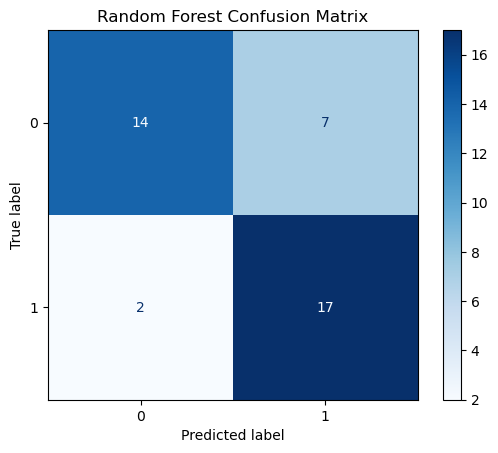

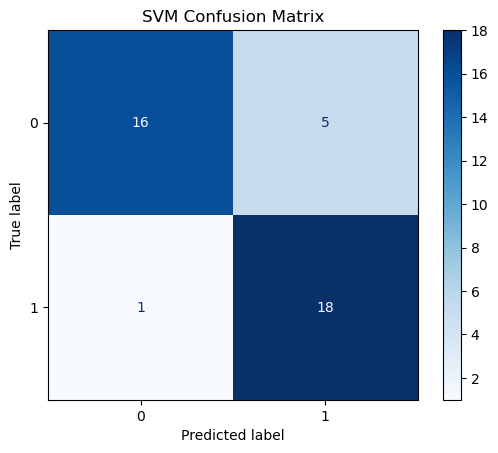

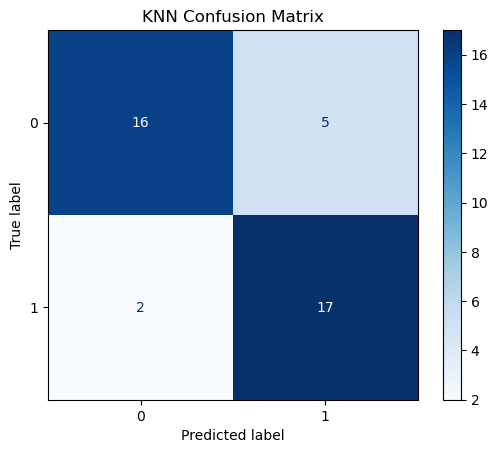

In [34]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")